The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.13.2 -f https://d2l.ai/whl.html # installing d2l


# Multilayer Perceptrons
:label:`sec_mlp`

In the previous chapter, we introduced 
softmax regression (:numref:`sec_softmax`), 
implementing the algorithm from scratch 
(:numref:`sec_softmax_scratch`) and in gluon 
(:numref:`sec_softmax_gluon`)
and training classifiers to recognize 
10 categories of clothing from low-resolution images.
Along the way, we learned how to wrangle data,
coerce our outputs into a valid probability distribution 
(via `softmax`),
apply an appropriate loss function,
and to minimize it with respect to our model's parameters.
Now that we have mastered these mechanics
in the context of simple linear models,
we can launch our exploration of deep neural networks,
the comparatively rich class of models 
with which this book is primarily concerned.

## Hidden Layers

To begin, recall the model architecture 
corresponding to our softmax regression example,
illustrated in  :numref:`fig_singlelayer` below.
This model mapped our inputs directly to our outputs
via a single linear transformation:

$$
\hat{\mathbf{o}} = \mathrm{softmax}(\mathbf{W} \mathbf{x} + \mathbf{b}).
$$

![Single layer perceptron with 5 output units.](http://d2l.ai/_images/singlelayer.svg)
:label:`fig_singlelayer`

If our labels truly were related 
to our input data by a linear function, 
then this approach would be sufficient.
But linearity is a *strong assumption*.

For example, linearity implies the *weaker*
assumption of *monotonicity*: 
that any increase in our feature must
either always cause an increase in our model's output 
(if the corresponding weight is positive),
or always always cause a decrease in our model's output
(if the corresponding weight is negative).
Sometimes that makes sense. 
For example, if we were trying to predict 
whether an individual will repay a loan,
we might reasonably imagine that holding all else equal,
an applicant with a higher income
would always be more likely to repay 
than one with a lower income.
While monotonic, this relationship likely
is not linearly associated with the probability of 
repayment. An increase in income from 0 to 50k 
likely corresponds to a bigger increase 
in likelihood of repayment 
than an increase from 1M to 1.05M.
One way to handle this might be to pre-process
our data such that linearity becomes more plausible, 
say, by using the logarithm of income as our feature.


Note that we can easily come up with examples
that violate *monotonicity*.
Say for example that we want to predict probability
of death based on body temperature. 
For individuals with a body temperature 
above 37°C (98.6°F),
higher termperatures indicate greater risk.
However, for individuals with body termperatures
below 37° C, higher temperatures indicate *lower* risk! 
In this case too, we might resolve the problem 
with some clever preprocessing. 
Namely, we might use the *distance* from 37°C as our feature. 


But what about classifying images of cats and dogs?
Should increasing the intensity 
of the pixel at location (13, 17)
always increase (or always decrease) 
the likelihood that the image depicts a dog?
Reliance on a linear model corrsponds to the (implicit)
assumption that the only requirement
for differentiating cats vs. dogs is to assess 
the brightness of individual pixels.
This approach is doomed to fail in a world
where inverting an image preserves the category.


And yet despite the apparent absurdity of linearity here,
as compared to our previous examples, 
it is less obvious that we could address the problem
with a simple preprocessing fix. 
That is because the significance of any pixel
depends in complex ways on its context 
(the values of the surrounding pixels).
While there might exist a representation of our data
that would take into account 
the relevant interactions among our features 
(and on top of which a linear model would be suitable),
we simply do not know how to calculate it by hand.
With deep neural networks, we used observational data
to jointly learn both a representation (via hidden layers)
and a linear predictor that acts upon that representation.


### Incorporating Hidden Layers

We can overcome these limitations of linear models
and handle a more general class of functions
by incorporating one or more hidden layers.
The easiest way to do this is to stack
many fully-connected layers on top of each other.
Each layer feeds into the layer above it, 
until we generate an output.
We can think of the first $L-1$ layers 
as our representation and the final layer
as our linear predictor. 
This architecture is commonly called 
a *multilayer perceptron*,
often abbreviated as *MLP*.
Below, we depict an MLP diagramtically (:numref:`fig_nlp`).

![Multilayer perceptron with hidden layers. This example contains a hidden layer with 5 hidden units in it. ](http://d2l.ai/_images/mlp.svg)
:label:`fig_nlp`

This multilayer perceptron has 4 inputs, 3 outputs,
and its hidden layer contains 5 hidden units.
Since the input layer does not involve any calculations,
producing outputs with this network
requires implementing the computations 
for each of the 2 layers (hidden and output).
Note that these layers are both fully connected.
Every input influences every neuron in the hidden layer,
and each of these in turn influences 
every neuron in the output layer.


### From Linear to Nonlinear

Formally, we calculate each layer 
in this one-hidden-layer MLP as follows:
$$
\begin{aligned}
    \mathbf{h} & = \mathbf{W}_1 \mathbf{x} + \mathbf{b}_1, \\
    \mathbf{o} & = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2, \\
    \hat{\mathbf{y}} & = \mathrm{softmax}(\mathbf{o}).
\end{aligned}
$$

Note that after adding this layer,
our model now requires us to track and update
two additional sets of parameters.
So what have we gained in exchange?
You might be surprised to find out 
that---in the model defined above---*we 
gain nothing for our troubles!*
The reason is plain. 
The hidden units above are given by 
a linear function of the inputs,
and the outputs (pre-softmax) are just 
a linear function of the hidden units.
A linear function of a linear function 
is itself a linear function.
Moreover, our linear model was already 
capable of representing any linear function.


We can view the equivalence formally
by proving that for any values of the weights,
we can just collapse out the hidden layer,
yielding an equivalent single-layer model with paramters
$\mathbf{W} = \mathbf{W}_2 \mathbf{W}_1$ and $\mathbf{b} = \mathbf{W}_2 \mathbf{b}_1 + \mathbf{b}_2$.

$$\mathbf{o} = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2 = \mathbf{W}_2 (\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2 = (\mathbf{W}_2 \mathbf{W}_1) \mathbf{x} + (\mathbf{W}_2 \mathbf{b}_1 + \mathbf{b}_2) = \mathbf{W} \mathbf{x} + \mathbf{b}.$$

In order to realize the potential of multilayer architectures,
we need one more key ingredient---an 
elementwise *nonlinear activation function* $\sigma$ 
to be applied to each hidden unit 
(following the linear transformation).
The most popular choice for the nonlinearity 
these days is the rectified linear unit (ReLU) 
$\mathrm{max}(x, 0)$.
In general, with these activation functions in place,
it is no longer possible to collapse our MLP into a linear model.

$$
\begin{aligned}
    \mathbf{h} & = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1), \\
    \mathbf{o} & = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2, \\
    \hat{\mathbf{y}} & = \mathrm{softmax}(\mathbf{o}).
\end{aligned}
$$

To build more general MLPs, we can continue stacking 
such hidden layers,
e.g., $\mathbf{h}_1 = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1)$
and $\mathbf{h}_2 = \sigma(\mathbf{W}_2 \mathbf{h}_1 + \mathbf{b}_2)$,
one atop another, yielding ever more expressive models
(assuming fixed width). 

MLPs can capture complex interactions 
among our inputs via their hidden neurons, 
which depend on the values of each of the inputs.
We can easily design hidden nodes 
to perform arbitrary computation,
for instance, basic logic operations on a pair of inputs.
Moreover, for certain choices of the activation function,
it is widely known that MLPs are universal approximators.
Even with a single-hidden-layer network,
given enough nodes (possibly absurdly many), 
and the right set of weights,
we can model any function.
*Actually learning that function is the hard part.*
You might think of your neural network 
as being a bit like the C programming language. 
The language, like any other modern language,
is capable of expressing any computable program.
But actually coming up with a program 
that meets your specifications is the hard part.

Moreover, just because a single-layer network 
*can* learn any function 
does not mean that you should try 
to solve all of your problems 
with single-layer networks.
In fact, we can approximate many functions
much more compactly by using deeper (vs wider) networks.
We will touch upon more rigorous arguments in subsequent chapters,
but first let us actually build an MLP in code.
In this example, we’ll implement an MLP
with two hidden layers and one output layer.

### Vectorization and Minibatch

As before, by the matrix $\mathbf{X}$, 
we denote a minibatch of inputs.
The calculations to produce outputs 
from an MLP with two hidden layers
can thus be expressed:

$$
\begin{aligned}
    \mathbf{H}_1 & = \sigma(\mathbf{W}_1 \mathbf{X} + \mathbf{b}_1), \\
    \mathbf{H}_2 & = \sigma(\mathbf{W}_2 \mathbf{H}_1 + \mathbf{b}_2), \\
    \mathbf{O} & = \mathrm{softmax}(\mathbf{W}_3 \mathbf{H}_2 + \mathbf{b}_3).
\end{aligned}
$$

With some abuse of notation, we define the nonlinearity 
$\sigma$ to apply to its inputs in a row-wise fashion, 
i.e., one observation at a time.
Note that we are also using the notation for *softmax* 
in the same way to denote a row-wise operation.
Often, as in this section, the activation functions
that we apply to hidden layers are not merely row-wise, 
but component wise.
That means that after computing the linear portion of the layer,
we can calculate each nodes activation 
without looking at the values taken by the other hidden units.
This is true for most activation functions
(the batch normalization operation to be introduced in :numref:`sec_batch_norm` is a notable exception to that rule).

In [1]:
%matplotlib inline
from d2l import torch as d2l
import torch

## Activation Functions

Activation functions decide whether a neuron should be activated or not by 
calculating the weighted sum and further adding bias with it. 
They are differentiable operators to transform input signals to outputs, 
while most of them add non-linearity.
Because activation functions are fundamental to deep learning, 
let us briefly survey some common activation functions.

### ReLU Function

As stated above, the most popular choice,
due to both simplicity of implementation
its performance on a variety of predictive tasks 
is the rectified linear unit (ReLU).
ReLU provides a very simple nonlinear transformation.
Given the element $z$, the function is defined
as the maximum of that element and 0.

$$\mathrm{ReLU}(z) = \max(z, 0).$$

Informally, the ReLU function retains only positive
elements and discards all negative elements 
(setting the corresponding activations to 0).
To gain some intuition, we can plot the function.
Because it is used so commonly, `ndarray` 
supports the `relu` function as a native operator.
As you can see, the activation function is piecewise linear.

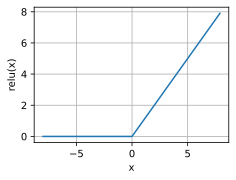

In [2]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.set_figsize((4, 2.5))
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)')

When the input is negative, 
the derivative of the ReLU function is 0,
and when the input is positive, 
the derivative of the ReLU function is 1.
Note that the ReLU function is not differentiable
when the input takes value precisely equal to 0.
In these cases, we default to the left-hand-side (LHS) 
derivative and say that the derivative is 0 when the input is 0.
We can get away with this because 
the input may never actually be zero.
There is an old adage that if subtle boundary conditions matter,
we are probably doing (*real*) mathematics, not engineering.
That conventional wisdom may apply here.
We plot the derivative of the ReLU function plotted below.

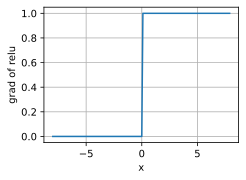

In [3]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu')

Note that there are many variants to the ReLU function, 
including the parameterized ReLU (pReLU) of [He et al., 2015](https://arxiv.org/abs/1502.01852). 
This variation adds a linear term to the ReLU, 
so some information still gets through, 
even when the argument is negative.

$$\mathrm{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$

The reason for using the ReLU is that 
its derivatives are particularly well behaved: 
either they vanish or they just let the argument through. 
This makes optimization better behaved 
and it mitigated the well-documented problem 
of *vanishing gradients* that plagued
previous versions of neural networks (more on this later).

### Sigmoid Function

The sigmoid function transforms its inputs,
for which values lie in the domain $\mathbb{R}$,
to outputs that lie on the interval $(0, 1)$.
For that reason, the sigmoid is 
often called a *squashing* function:
it *squashes* any input in the range (-inf, inf)
to some value in the range (0, 1).

$$\mathrm{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

In the earliest neural networks, scientists
were interested in modeling biological neurons
which either *fire* or *do not fire*.
Thus the pioneers of this field, 
going all the way back to McCulloch and Pitts, 
the inventors of the artificial neuron,
focused on thresholding units.
A thresholding activation takes value $0$
when its input is below some threshold
and value $1$ when the input exceeds the threshold.


When attention shifted to gradient based learning,
the sigmoid function was a natural choice
because it is a smooth, differentiable 
approximation to a thresholding unit.
Sigmoids are still widely used as 
activation functions on the output units,
when we want to interpret the outputs as probabilities
for binary classification problems
(you can think of the sigmoid as a special case of the softmax).
However, the sigmoid has mostly been replaced 
by the simpler and more easily trainable ReLU 
for most use in hidden layers.
In the "Recurrent Neural Network" chapter 
(:numref:`sec_plain_rnn`), 
we will describe architectures that leverage sigmoid units 
to control the flow of information across time.

Below, we plot the sigmoid function.
Note that when the input is close to 0, 
the sigmoid function approaches 
a linear transformation.

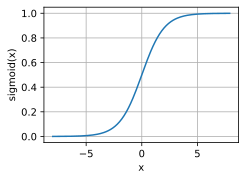

In [4]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)')

The derivative of the sigmoid function is given by the following equation:

$$\frac{d}{dx} \mathrm{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \mathrm{sigmoid}(x)\left(1-\mathrm{sigmoid}(x)\right).$$


The derivative of the sigmoid function is plotted below.
Note that when the input is 0, 
the derivative of the sigmoid function
reaches a maximum of 0.25. 
As the input diverges from 0 in either direction, 
the derivative approaches 0.

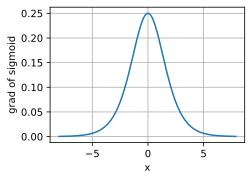

In [5]:
# Clear out previous gradients.
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid')

### Tanh Function

Like the sigmoid function, the tanh (Hyperbolic Tangent)
function also squashes its inputs,
transforming them into elements on the interval between -1 and 1:

$$\text{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

We plot the tanh function blow. Note that as the input nears 0, the tanh function approaches a linear transformation. Although the shape of the function is similar to the sigmoid function, the tanh function exhibits point symmetry about the origin of the coordinate system.

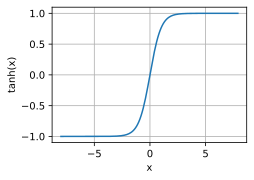

In [6]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)')

The derivative of the Tanh function is:

$$\frac{d}{dx} \mathrm{tanh}(x) = 1 - \mathrm{tanh}^2(x).$$

The derivative of tanh function is plotted below.
As the input nears 0,
the derivative of the tanh function approaches a maximum of 1.
And as we saw with the sigmoid function,
as the input moves away from 0 in either direction,
the derivative of the tanh function approaches 0.

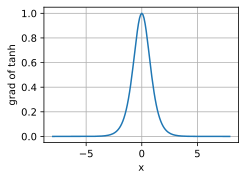

In [7]:
# Clear out previous gradients.
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh')

In summary, we now know how to incorporate nonlinearities
to build expressive multilayer neural network architectures.
As a side note, your knowledge already
puts you in command of a similar toolkit 
to a practitioner circa 1990.
In some ways, you have an advantage 
over anyone working in the 1990s,
because you can leverage powerful 
open-source deep learning frameworks
to build models rapidly, using only a few lines of code.
Previously, getting these nets training
required researchers to code up 
thousands of lines of C and Fortran.

## Summary

* The multilayer perceptron adds one or multiple fully-connected hidden layers between the output and input layers and transforms the output of the hidden layer via an activation function.
* Commonly-used activation functions include the ReLU function, the sigmoid function, and the tanh function.


## Exercises

1. Compute the derivative of the tanh and the pReLU activation function.
1. Show that a multilayer perceptron using only ReLU (or pReLU) constructs a continuous piecewise linear function.
1. Show that $\mathrm{tanh}(x) + 1 = 2 \mathrm{sigmoid}(2x)$.
1. Assume we have a multilayer perceptron *without* nonlinearities between the layers. In particular, assume that we have $d$ input dimensions, $d$ output dimensions and that one of the layers has only $d/2$ dimensions. Show that this network is less expressive (powerful) than a single layer perceptron.
1. Assume that we have a nonlinearity that applies to one minibatch at a time. What kinds of problems do you expect this to cause?



[Discussions](https://discuss.d2l.ai/t/91)